# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot


## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


# Préliminaires

## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time
from sklearn.metrics import accuracy_score

#### RBF SVM

In [4]:
# TODO

# train the model
print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
clf = SVC(kernel='rbf')
t0 = time()
clf.fit(X_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_kernel = t1-t0

# prediction
print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t0 = time()
y_pred = clf.predict(X_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_kernel += t1-t0
print("Total time : %0.3fs" % timing_kernel)

# accuracy score
accuracy_kernel = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting SVC rbf on 20000 samples...
done in 5.592s
Predicting with SVC rbf on 40000 samples...
done in 7.278s
Total time : 12.869s
classification accuracy: 0.980


#### Linear SVM

In [5]:
# TODO

# train the model
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
clf_lin = LinearSVC(dual=False)
t0 = time()
clf_lin.fit(X_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_linear = t1-t0

# prediction
print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t0 = time()
y_pred = clf_lin.predict(X_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_linear += t1-t0
print("Total time : %0.3fs" % timing_linear)

# accuracy score
accuracy_linear = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting LinearSVC on 20000 samples...
done in 0.105s
Predicting with LinearSVC on 40000 samples...
done in 0.015s
Total time : 0.120s
classification accuracy: 0.917


**Comment** :
The linear SVM is much faster (fit is about 30 times, prediction is about 1400 times !), but it comes at a cost in terms of accuracy (6% lost).

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [6]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        # TODO use svds
        u, s, vt = svds(gram_mat, k=k)
        #gram_mat_k = np.dot(u, np.dot(np.diag(s), vt))
        gram_mat_k = u @ np.diag(s) @ vt
    
    else:
        # TODO use svd
        u, s, vt = svd(gram_mat, full_matrices=False)
        #gram_mat_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]), vt[:k,:]))
        gram_mat_k = u[:,:k] @ np.diag(s[:k]) @ vt[:k,:]
    
    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [7]:
from numpy.linalg import norm

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = norm(gram_mat_k - gram_signal, 'fro') / norm(gram_signal, 'fro')

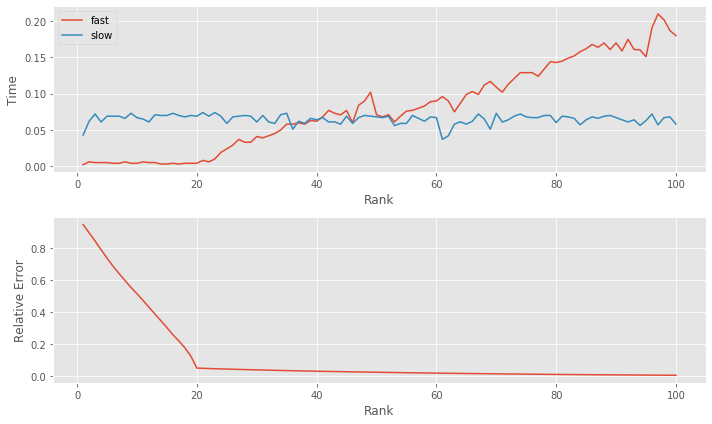

In [8]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()
ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')

ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')

plt.tight_layout()
plt.show()

A compléter

# Random Kernel Features

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [9]:
from math import pi

def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components (random features)
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    # TODO
    W = np.random.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = np.random.uniform(0, 2*pi, (1,c))

    #X_new_train = np.sqrt(2/n_features) * np.cos(np.dot(X_train, W) + b)
    #X_new_test = np.sqrt(2/n_features) * np.cos(np.dot(X_test, W) + b)
    X_new_train = np.sqrt(2/c) * np.cos((X_train @ W) + b)
    X_new_test = np.sqrt(2/c) * np.cos((X_test @ W) + b)

    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [10]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_rkf = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_rkf = clf.score(Z_test, y_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_rkf += t1-t0
print("Total time : %0.3fs" % timing_rkf)


print("classification accuracy: %0.3f" % accuracy_rkf)

Fitting SVC linear on 20000 samples...
done in 1.966s
Predicting with SVC linear on 40000 samples...
done in 0.044s
Total time : 2.010s
classification accuracy: 0.964


A compléter

# L'approximation de Nyström

## Question 6

On implémente la méthode de Nystrom.

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # TODO
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]
    
    #W_k = np.dot(u, np.dot(np.diag(s), vt))
    W_k = u @ np.diag(s) @ vt
    
    #M = np.dot(u, np.diag(1/np.sqrt(s)))
    M = u @ np.diag(1/np.sqrt(s))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    #X_new_train = np.dot(C_train, M)
    #X_new_test = np.dot(C_test, M)
    X_new_train = C_train @ M
    X_new_test = C_test @ M

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [12]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_nystrom = clf.score(Z_test, y_test)
t1= time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom += t1-t0
print("Total time : %0.3fs" % timing_nystrom)

print("classification accuracy: %0.3f" % accuracy_nystrom)

Fitting SVC linear on 20000 samples...
done in 1.738s
Predicting with SVC linear on 40000 samples...
done in 0.046s
Total time : 1.784s
classification accuracy: 0.976


A compléter

# Synthèse des résultats

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [13]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    
    ## Nystorm
    Z_ny_train, Z_ny_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_ny_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_ny_test, y_test)
    timing_nystrom[i] = time() - t0

    ## RKF
    Z_rkf_train, Z_rkf_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_rkf_train, y_train)
    accuracy_rkf[i] = clf.score(Z_rkf_test, y_test)
    timing_rkf[i] = time() - t0


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


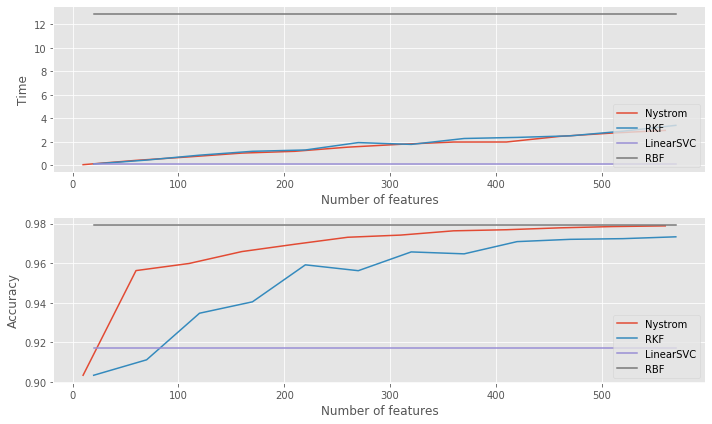

In [14]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

A compléter